# Terner Labs Economist/Data Analyst Technical Exercise

This is a technical exercise for a position at Terner Labs. It has two components. The first section involves testing for basic coding competency in Python and geopandas and the second section gives space to showcase my skills. The code will be heavily annotated and I will narrate/state my assumptions wherever I make any judgement calls. 

## Prepare environment, import libraries and load data
I created a virtual environment specifically for this task. See `README.md` for how to recreate it.


In [1]:
# install packages
#%pip install geopandas pandas matplotlib seaborn pygris
#%pip install "folium>=0.12" matplotlib mapclassify


In [2]:

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# settings
%matplotlib inline
pd.set_option("display.max_columns", None) # set off to see all columns



All of shapefiles can be found [here](https://data.sanjoseca.gov/organization/maps-data).

In [3]:
# load data
parcels = gpd.read_file("../data/Parcels/Parcels.shp")
zoning = gpd.read_file("../data/Zoning_Districts/Zoning_Districts.shp")
railroad = gpd.read_file("../data/Railroad/Railroad.shp")
bikeways = gpd.read_file("../data/Bikeways/Bikeways.shp")
bikeracks = gpd.read_file("../data/Bike_Racks/Bike_Racks.shp")
affordable_housing = gpd.read_file("../data/Affordable_Rental_Housing/Affordable_Rental_Housing.shp")
equity = gpd.read_file("../data/Equity_Index_Census_Tracts/Equity_Index_Census_Tracts.shp")

# remove union pacific since its a freight train
railroad = railroad.query("NAME != 'Union Pacific' ")


/opt/anaconda3/envs/housing_project/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/opt/anaconda3/envs/housing_project/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 4274 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(


In [4]:
# view parcels
parcels.head()  


,OBJECTID,PARCELID,INTID,APN,LOTNUM,PARCELTYPE,FEATURECLA,PLANCRT,PLANMOD,LASTUPDATE,NOTES,COVERED,SHAPE_Leng,SHAPE_Area,CREATIONDA,geometry
0,1,568,568,23712112,7,Tax,Parcel,MGE,None,2005-10-25,None,None,694.824660,30293.181866,1900-01-01,"POLYGON ((6152190.18 1960992.53, 6152117.6 196..."
1,2,508,508,23717101,1,Tax,Parcel,MGE,None,2005-10-25,None,None,1091.096404,67674.864533,1900-01-01,"POLYGON ((6149855.9 1962848.74, 6149591.14 196..."
2,3,509,509,23717102,2,Tax,Parcel,MGE,None,2005-10-25,None,None,1308.365727,101464.923357,1900-01-01,"POLYGON ((6150024.95 1962661.16, 6149801.39 19..."
3,4,510,510,23717099,A,Tax,Parcel,MGE,None,2005-10-25,None,None,928.437778,51153.749677,1900-01-01,"POLYGON ((6149690.78 1962949.62, 6149484.72 19..."
4,5,11908,11908,58705049,74,Tax,Parcel,T-3252,None,2005-10-25,None,None,339.402106,6568.968404,1900-01-01,"POLYGON ((6169021.55 1973009.12, 6169053.1 197..."


In [5]:
# view zoning data 
zoning.head()

,OBJECTID,FACILITYID,INTID,ZONING,ZONINGABBR,REZONINGFI,PDUSE,PDDENSITY,DEVELOPEDA,APPROVALDA,COLORCODE,LASTUPDATE,NOTES,SHAPE_Leng,SHAPE_Area,geometry
0,1,1,1,A,A,None,None,0,None,None,17,2022-04-22,None,856.089583,4.495781e+04,"POLYGON ((6193968.23 1891446.99, 6193780.24 18..."
1,2,2,2,A,A,None,None,0,None,None,17,2022-04-22,None,15784.038147,6.765505e+06,"POLYGON ((6195588.513 1891335.018, 6196508.11 ..."
2,3,3,3,A,A,None,None,0,None,None,17,2022-04-22,None,4548.408852,4.885912e+05,"POLYGON ((6193048.64 1892200.24, 6193097.11 18..."
3,4,4,4,A,A,None,None,0,None,None,17,2022-04-22,None,17137.289845,1.136541e+07,"POLYGON ((6192765.192 1896544.75, 6193127.218 ..."
4,5,5,5,R-1-5,R-1-5,C20-007,None,0,None,None,1,2022-04-22,None,2236.203702,5.718252e+04,"POLYGON ((6173652.791 1897712.091, 6173640.15 ..."


## SECTION A
### 1. How many parcels are there in each zone?

**PROMPT:** Find the San Jose Parcels in Urban Village, Mixed Use Commercial, Urban Residential, and Transit Residential zones (zoning codes here). How many Parcels are there in each of these zones?

- Join the zoning geometries to the parcel geometries to find which zone the parcel falls into
- Note that some parcels may overlap with more than one zone. We suggest you write a custom function in a separate .py file that returns only one overlapping zone per parcel
- Determine how many parcels are in each zone

**WHAT I DID:** I first visualized the shapefiles so I could better understand the problem and become more familiar with the data. I then spatially joined the parcel with the zoning shapefile but left the multiple record issue unaddressed so I could visually inspect the results. I then made sure my approach to select the parcel with the largest overlapping area was appropriate, selected the parcel with the largest overlap, counted the number of parcels by each of the 4 zoning districts, and then visualized the result. 

#### 1.1 Visual the shapefile

I first wanted to visualize the shapefiles I'd be working with and inspect the distribution of 4 zoning types pertaining to this question. 

In [6]:
# 4 zoning types of foucus
# --------
# Urban Village             = UV
# Mixed Use Commercial      = MUC
# Urban Residential         = UR
# Transit Residential       = TR

# subset out only the 4 zoning types I will focus on
zoning4 = zoning.query("ZONING == 'UV'or ZONING == 'MUC' or ZONING == 'UR' or ZONING == 'TR' ")

# subset specifically Urban Village
zoning_uv = zoning.query("ZONING == 'UV'")

<Axes: >

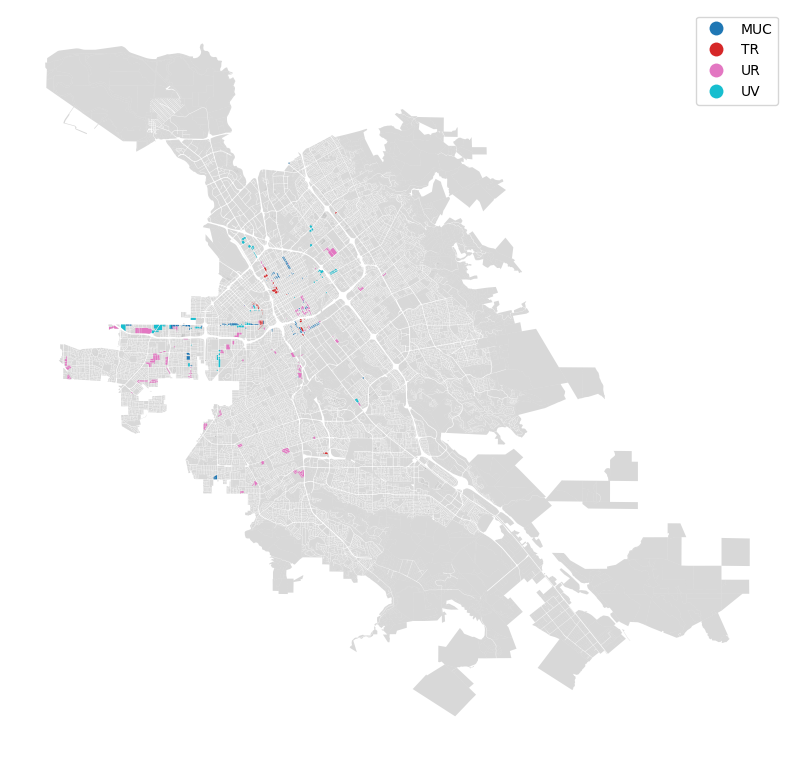

In [7]:
# overlay the zoning types on the parcel shapefile and set each zoning type as a different color
# --------
fig, ax  = plt.subplots(figsize=(10,12))
ax.axis('off')
parcels.plot(ax = ax, color = 'grey', alpha = 0.3, legend = True)
zoning4.plot(ax = ax, column = 'ZONING', legend = True)

#### 1.2 Spatial join

Join the parcel and the zoning shapefiles together to find which zone the parcel falls into. I wrote a function contained in `util.py` called `sjoin_parcels_to_zd`. While the instructions said to ensure it only returned on parcel per zoning district, I preferred to do that at a latter step to ensure the function was working correctly and I could visualize some of the overlaps and better understand the data. 

In [8]:
# execute spatial join function
from utils import sjoin_parcels_to_zd
parcels_in_zd = sjoin_parcels_to_zd(parcels, zoning, how="largest")


In [9]:
# inspect join
parcels_in_zd.head()

,OBJECTID_left,PARCELID,INTID_left,APN,LOTNUM,PARCELTYPE,FEATURECLA,PLANCRT,PLANMOD,LASTUPDATE_left,NOTES_left,COVERED,SHAPE_Leng_left,SHAPE_Area_left,CREATIONDA,geometry,OBJECTID_right,FACILITYID,INTID_right,ZONING,ZONINGABBR,REZONINGFI,PDUSE,PDDENSITY,DEVELOPEDA,APPROVALDA,COLORCODE,LASTUPDATE_right,NOTES_right,SHAPE_Leng_right,SHAPE_Area_right,overlap_area
0,1,568,568,23712112,7,Tax,Parcel,MGE,None,2005-10-25,None,None,694.824660,30293.181866,1900-01-01,"POLYGON ((6152190.18 1960992.53, 6152117.6 196...",7743.0,7743,7743.0,HI,HI,None,None,0,None,None,15,2022-04-22,None,1181.808558,62997.552672,30288.801759
1,2,508,508,23717101,1,Tax,Parcel,MGE,None,2005-10-25,None,None,1091.096404,67674.864533,1900-01-01,"POLYGON ((6149855.9 1962848.74, 6149591.14 196...",624.0,624,624.0,A(PD),A(PD),70072,Ind,0,Yes,None,17,2022-04-22,None,2704.667984,346896.334819,67657.267483
1,2,508,508,23717101,1,Tax,Parcel,MGE,None,2005-10-25,None,None,1091.096404,67674.864533,1900-01-01,"POLYGON ((6149855.9 1962848.74, 6149591.14 196...",663.0,663,663.0,A(PD),A(PD),73112,Com,0,Yes,None,17,2022-04-22,None,1622.181189,86427.337276,0.000000
1,2,508,508,23717101,1,Tax,Parcel,MGE,None,2005-10-25,None,None,1091.096404,67674.864533,1900-01-01,"POLYGON ((6149855.9 1962848.74, 6149591.14 196...",2244.0,2244,2244.0,CG,CG,00111,None,0,None,None,7,2022-04-22,None,1725.781095,173391.392840,0.000000
2,3,509,509,23717102,2,Tax,Parcel,MGE,None,2005-10-25,None,None,1308.365727,101464.923357,1900-01-01,"POLYGON ((6150024.95 1962661.16, 6149801.39 19...",3088.0,3088,3088.0,IP(PD),IP(PD),90068,Com,0,Yes,None,13,2022-04-22,None,1333.366841,107116.764778,0.000000


##### Visual check 1

To ensure it worked correctly, I found two example parcels that I knew were in multiple zoning districts and visualized them separately. I made to sure to keep the multiple parcel records so I could ensure the function was using my chosen method (chose the parcel with the largest overlap area) to correctly identify the parcel I wanted to keep. The overlap in the first example parcel seems to mostly to be boundaries overlapping, rather than much of the polygons. 

In [10]:
# In this case, the parcel boundaries overlap with three zoning districts but only one has much coverage.
parcels_in_zd[parcels_in_zd["PARCELID"] == "508"]

,OBJECTID_left,PARCELID,INTID_left,APN,LOTNUM,PARCELTYPE,FEATURECLA,PLANCRT,PLANMOD,LASTUPDATE_left,NOTES_left,COVERED,SHAPE_Leng_left,SHAPE_Area_left,CREATIONDA,geometry,OBJECTID_right,FACILITYID,INTID_right,ZONING,ZONINGABBR,REZONINGFI,PDUSE,PDDENSITY,DEVELOPEDA,APPROVALDA,COLORCODE,LASTUPDATE_right,NOTES_right,SHAPE_Leng_right,SHAPE_Area_right,overlap_area
1,2,508,508,23717101,1,Tax,Parcel,MGE,None,2005-10-25,None,None,1091.096404,67674.864533,1900-01-01,"POLYGON ((6149855.9 1962848.74, 6149591.14 196...",624.0,624,624.0,A(PD),A(PD),70072,Ind,0,Yes,None,17,2022-04-22,None,2704.667984,346896.334819,67657.267483
1,2,508,508,23717101,1,Tax,Parcel,MGE,None,2005-10-25,None,None,1091.096404,67674.864533,1900-01-01,"POLYGON ((6149855.9 1962848.74, 6149591.14 196...",663.0,663,663.0,A(PD),A(PD),73112,Com,0,Yes,None,17,2022-04-22,None,1622.181189,86427.337276,0.000000
1,2,508,508,23717101,1,Tax,Parcel,MGE,None,2005-10-25,None,None,1091.096404,67674.864533,1900-01-01,"POLYGON ((6149855.9 1962848.74, 6149591.14 196...",2244.0,2244,2244.0,CG,CG,00111,None,0,None,None,7,2022-04-22,None,1725.781095,173391.392840,0.000000


<Axes: >

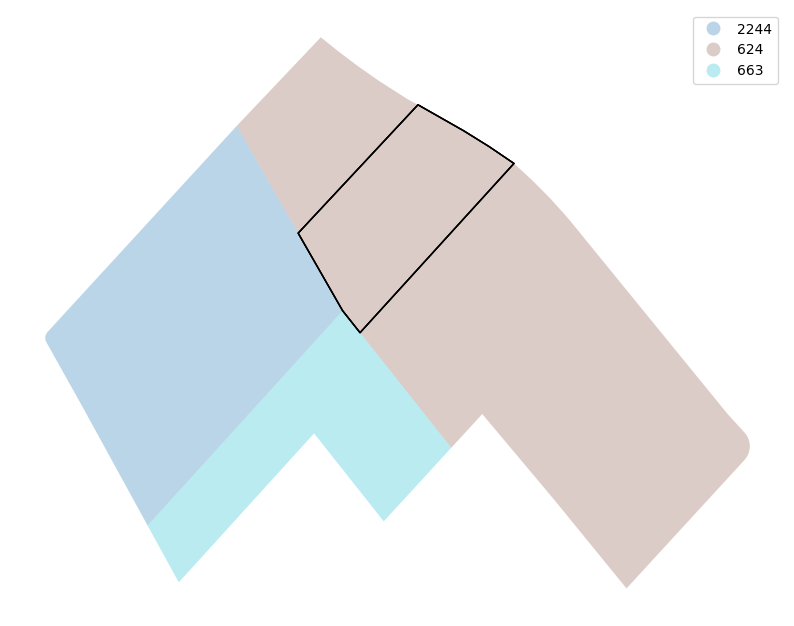

In [11]:
# identify parcel with overlapping zoning districts
# ----------
parcel508 = parcels_in_zd[parcels_in_zd["PARCELID"] == "508"]
zoning508 = zoning[zoning["FACILITYID"].isin(["624", "663", "2244"])]

# plot 
# ----------
fig, ax  = plt.subplots(figsize=(10,12))
ax.axis('off')

# plot zoning shapefile
zoning508.plot(ax = ax, column = 'FACILITYID', alpha = 0.3, legend = True)
# plot border of parcel
parcel508.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)


##### Visual check 2

The overlap in the second example parcel seems to be more complex since the boundaries of the parcel are firmly contained in two differ zoning districts. By calculating the area of the overlap in each zoning district, I have a sense of how much each parcel overlaps. For this analysis, I've decided it is sufficient to simply assign the parcel to the zoning district that has the greatest overlap. In a more complex analysis or one with different goals, I might create a zoning hierarchy whereby I assign the parcel based on the hierarchy, for example, I might assign a parcel to a residential zoning over a commercial zoning. 

In [12]:
# Example case 2: this is a much messier example since the parcel overlaps much more equally with both zoning districts. 
# In this case, I'd want to keep parcel 12244 since the overlap area is larger. The visualization confirms this, albeit it is much more difficult to see
parcels_in_zd[parcels_in_zd["PARCELID"] == "1000027366"]

,OBJECTID_left,PARCELID,INTID_left,APN,LOTNUM,PARCELTYPE,FEATURECLA,PLANCRT,PLANMOD,LASTUPDATE_left,NOTES_left,COVERED,SHAPE_Leng_left,SHAPE_Area_left,CREATIONDA,geometry,OBJECTID_right,FACILITYID,INTID_right,ZONING,ZONINGABBR,REZONINGFI,PDUSE,PDDENSITY,DEVELOPEDA,APPROVALDA,COLORCODE,LASTUPDATE_right,NOTES_right,SHAPE_Leng_right,SHAPE_Area_right,overlap_area
224906,415373,1000027366,1000027366,46255???,None,Tax,Parcel,T-5612,AT24-010,2025-07-23,None,No,659.028878,16929.485228,2025-07-23,"POLYGON ((6167596.59 1921709.25, 6167600.382 1...",12244.0,12244,12244.0,R-1-1,R-1-1,None,None,0,None,None,1,2022-04-22,None,1328.174162,50514.326282,9881.394168
224906,415373,1000027366,1000027366,46255???,None,Tax,Parcel,T-5612,AT24-010,2025-07-23,None,No,659.028878,16929.485228,2025-07-23,"POLYGON ((6167596.59 1921709.25, 6167600.382 1...",9207.0,9207,9207.0,R-1-8,R-1-8,None,None,0,None,None,1,2022-04-22,None,4151.941871,310402.455183,7048.968324


<Axes: >

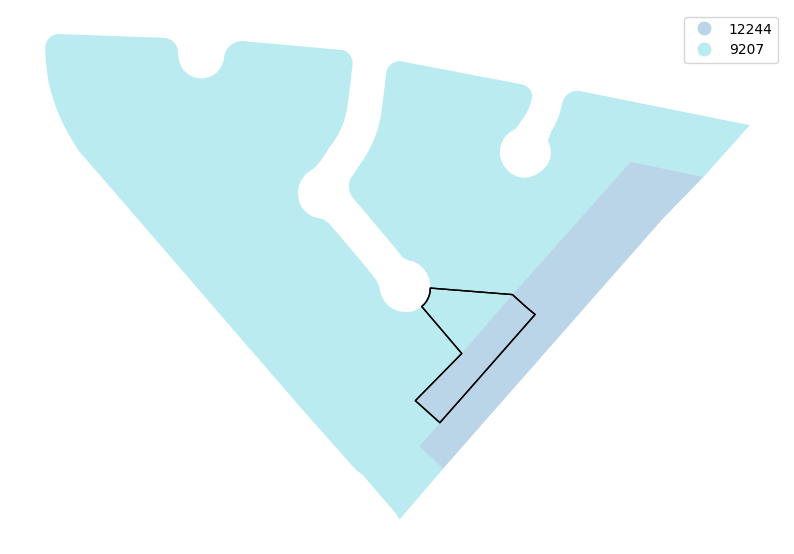

In [13]:
# identify parcel with overlapping zoning districts
# ----------
parcel1000027366 = parcels_in_zd[parcels_in_zd["PARCELID"] == "1000027366"]
zoning1000027366 = zoning[zoning["FACILITYID"].isin(["12244", "9207"])]


# plot 
# ----------
fig, ax  = plt.subplots(figsize=(10,12))
ax.axis('off')

# plot zoning shapefile
zoning1000027366.plot(ax = ax, column = 'FACILITYID', alpha = 0.3, legend = True)
# plot border of parcel
parcel1000027366.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)



#### 1.3 Remove multiple parcels
Now that I have visually inspected that the function worked, I want to choose only the one parcel that has the largest `overlap_area`. 

In [14]:
# remove multiple parcels
parcels_in_zd_unique = (
    # sort by PARCELID ascending but overlap_area descending, so largest overlap_area value is at top
    parcels_in_zd.sort_values(["PARCELID", "overlap_area"], ascending=[True, False])
          # drop duplicates but keep first record (which is the largest)
          .drop_duplicates(subset="PARCELID", keep="first")
          # reset index
          .reset_index(drop=True)
)

In [15]:
# check number of rows in parcel == number of rows in new parcel shapefile, meaning each parcel has one zoning district
# output should be true
parcels.shape[0] == parcels_in_zd_unique.shape[0]

True

#### 1.4 Count the number of parcels in each zone

Now I can sum the total parcels by zone to determine how many parcels are in each zone. I chose to plot the output to make the results more clear.


<positron-console-cell-16>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



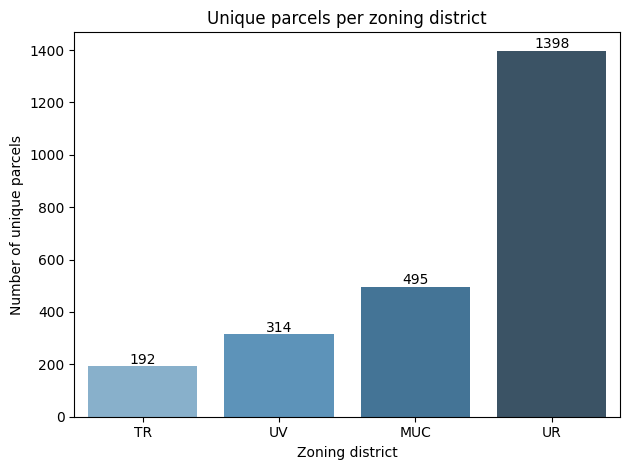

In [16]:
# Define the zones you want to filter
zones = ["UV", "MUC", "UR", "TR"]

# Count unique parcels per zoning district in one step
count = (
    parcels_in_zd_unique[parcels_in_zd_unique["ZONING"].isin(zones)]
    .groupby("ZONING")["PARCELID"]
    .nunique()
)

# Reset index and rename column
count_df = count.reset_index().rename(columns={'PARCELID': 'unique_parcels'})

# Sort by count
count_df = count_df.sort_values(by='unique_parcels', ascending=True)

# Create barplot
ax = sns.barplot(data=count_df, x='ZONING', y='unique_parcels', palette='Blues_d')

# Add text labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width()/2,   # center of the bar
        y=height + 10,                   # slightly above the bar
        s=int(height),                   # the count as integer
        ha='center'
    )

# Labels and title
plt.xlabel('Zoning district')
plt.ylabel('Number of unique parcels')
plt.title('Unique parcels per zoning district')
plt.tight_layout()
plt.show()


### 2. Total acreage across all parcels in each zone

**PROMPT:** Calculate the total acreage across all parcels in each zone. Which zone, Urban Village or
Urban Residential has the highest possible number of dwelling units based solely on the
maximum dwelling unit per acre (du/ac) allowance for 100% residential development? You will
need table Table 20-136 in the San Jose city code here. Also, please note the unit for the SHAPE_Area variable in the Parcel data set is in square feet.

**WHAT I DID** I first needed to convert 1 acre to square feet. A bit of googleing shows that `1 acre = 43,560 square feet.` I then subset my `parcels_in_zd_unique` shapefile to only include the 2 zones I wanted to focus on. I then sum the `SHAPE_Area_right` variable by the two zones and convert from square feet to acres. I then divide the total acreage by the upper and lower limits and see which zone has higher numbers. 

Based on [Table 20-136](https://library.municode.com/ca/san_jose/codes/code_of_ordinances?nodeId=TIT20ZO_CH20.55URVIMIUSZODI_PT2DERE_20.55.100DEST), **Urban residential** has the highest possible number of dwelling units based solely on the maximum dwelling unit per acre (du/ac) allowance for 100% residential development. 

#### 2.1 Subset to just two zoning districts

In [17]:

# Define the zones you want to filter
zones2 = ["UV", "UR"]

#  subset just the 4 zones
parcels_in_2_zones = parcels_in_zd_unique[parcels_in_zd_unique["ZONING"].isin(zones2)]

parcels_in_2_zones.head()

,OBJECTID_left,PARCELID,INTID_left,APN,LOTNUM,PARCELTYPE,FEATURECLA,PLANCRT,PLANMOD,LASTUPDATE_left,NOTES_left,COVERED,SHAPE_Leng_left,SHAPE_Area_left,CREATIONDA,geometry,OBJECTID_right,FACILITYID,INTID_right,ZONING,ZONINGABBR,REZONINGFI,PDUSE,PDDENSITY,DEVELOPEDA,APPROVALDA,COLORCODE,LASTUPDATE_right,NOTES_right,SHAPE_Leng_right,SHAPE_Area_right,overlap_area
1013,2339,1000001688,1000001688,41221013,None,Tax,Parcel,T-3756,None,2006-04-03,Distance only.,None,254.996519,509.127245,1900-01-01,"POLYGON ((6145435.829 1926433.08, 6145437.15 1...",31155.0,28843,28843.0,UR,UR,C22-121,None,0,None,2023/06/13,6,2024-04-10,ORD30922,254.996519,509.115978,509.115978
1903,202959,1000003060,1000003060,47224111,None,Tax,Parcel,T-9621,None,2006-05-05,None,None,437.231119,11680.913709,1900-01-01,"POLYGON ((6161624.82 1945490.22, 6161647.59 19...",11873.0,11873,11873.0,UR,UR,C22-065,None,0,None,2022/08/30,6,2024-04-10,None,1174.776437,58009.454083,11680.910092
2389,209441,1000003699,1000003699,23502034,None,Tax,Parcel,MGE,None,2022-12-19,"APN discrepancy, updated from 031.",None,1801.491831,62811.757259,1900-01-01,"POLYGON ((6151830.01 1958367.12, 6151921.86 19...",30314.0,28768,28768.0,UV,UV,C23-088,None,None,None,2023/05/16,7,2024-04-11,None,2288.775356,150285.909739,62811.741795
2390,6399,1000003700,1000003700,23502033,None,Tax,Parcel,MGE,None,2006-04-04,None,None,1016.858199,64451.725602,1900-01-01,"POLYGON ((6151763.51 1958319.93, 6151894.86 19...",30314.0,28768,28768.0,UV,UV,C23-088,None,None,None,2023/05/16,7,2024-04-11,None,2288.775356,150285.909739,64451.725602
2622,202958,1000004030,1000004030,47720030,1,Tax,Parcel,MGE,None,2006-07-24,None,None,411.916444,10202.866820,1900-01-01,"POLYGON ((6167914.439 1939878.351, 6167969.276...",3132.0,3132,3132.0,UR,UR,C22-121,None,0,None,2023/06/13,6,2024-04-10,ORD30922,411.916444,10202.866820,10202.866820


#### 2.2 Calculate total acreage

In [18]:
# sum parcel areas by zoning (convert to acres)
total_acreage_by_zone = (
    parcels_in_2_zones.groupby('ZONING')['SHAPE_Area_right']
    .sum() / 43560  # convert square feet to acres
)

# turn into a DataFrame for ease of viewing
total_acreage_by_zone = total_acreage_by_zone.reset_index().rename(columns={'SHAPE_Area_right': 'total_acreage'})

# view
print(total_acreage_by_zone)



  ZONING  total_acreage
0     UR    5619.180377
1     UV    1032.238010


#### 2.3 Compare 

In [19]:
# UR 100% Residential du/ac : 30 - 95 
print(5619.180377/30)
print(5619.180377/95)


187.30601256666665
59.149267126315785


In [20]:
# UV 100% Residential du/ac : 55 - 250
print(1032.238010/55)
print(1032.238010/250)

18.76796381818182
4.12895204


Based on [Table 20-136](https://library.municode.com/ca/san_jose/codes/code_of_ordinances?nodeId=TIT20ZO_CH20.55URVIMIUSZODI_PT2DERE_20.55.100DEST), **Urban residential** has the highest possible number of dwelling units based solely on the maximum dwelling unit per acre (du/ac) allowance for 100% residential development. 

### 3. Number of Urban Village parcels within 1 mile of San Jose Diridon Station

**PROMPT:** Calculate the number of Urban Village parcels within a mile of the San Jose Diridon Station.

**WHAT I DID:** I first thought it might be easy to identify either a parcel designated as San Jose Diridon Station or a special zoning district but was unsuccessful and was not confident in what I did find. Next, I downloaded a shapefile for the railroad lines from the website provided. Although Diridon Station is a Caltrain line, the rail lines were not as helpful as I'd hoped in locating Diridon Station. Finally, I googled the coordinates in decimal degrees, set it as a point and spatially joined it to the parcel shapefile to identify all parcels within 1 mile. I found this to be the most reliable approach. 

#### 3.1 Spatial join

In [21]:

# 1. Ensure everything in projected CRS (meters) 
# Choose a local projection for San Jose (NAD83 / California zone 3 ft = EPSG:2227, or just Web Mercator EPSG:3857 for simplicity)
parcels_in_zd = parcels_in_zd.to_crs(epsg=3857)

# Diridon Station coordinates (lon, lat in WGS84)
diridon_station = gpd.GeoDataFrame(
    geometry=[Point(-121.9028, 37.3292)],
    crs="EPSG:4326"
).to_crs(parcels_in_zd.crs)

# 2. Buffer the point 
buffer_1mile = diridon_station.buffer(1609.34)   # 1 mile
buffer_2mile = diridon_station.buffer(2 * 1609.34)  # 2 miles

# 3. Subset parcels to only within 2 miles 
parcels_within_2mile = gpd.overlay(parcels_in_zd, gpd.GeoDataFrame(geometry=buffer_2mile, crs=parcels_in_zd.crs), how="intersection")

# 4. Identify UV parcels within 1 mile 
parcels_within_1mile = gpd.overlay(parcels_in_zd, gpd.GeoDataFrame(geometry=buffer_1mile, crs=parcels_in_zd.crs), how="intersection")
uv_within_1mile = parcels_within_1mile[parcels_within_1mile["ZONING"] == "UV"]




#### 3.2 Visualize

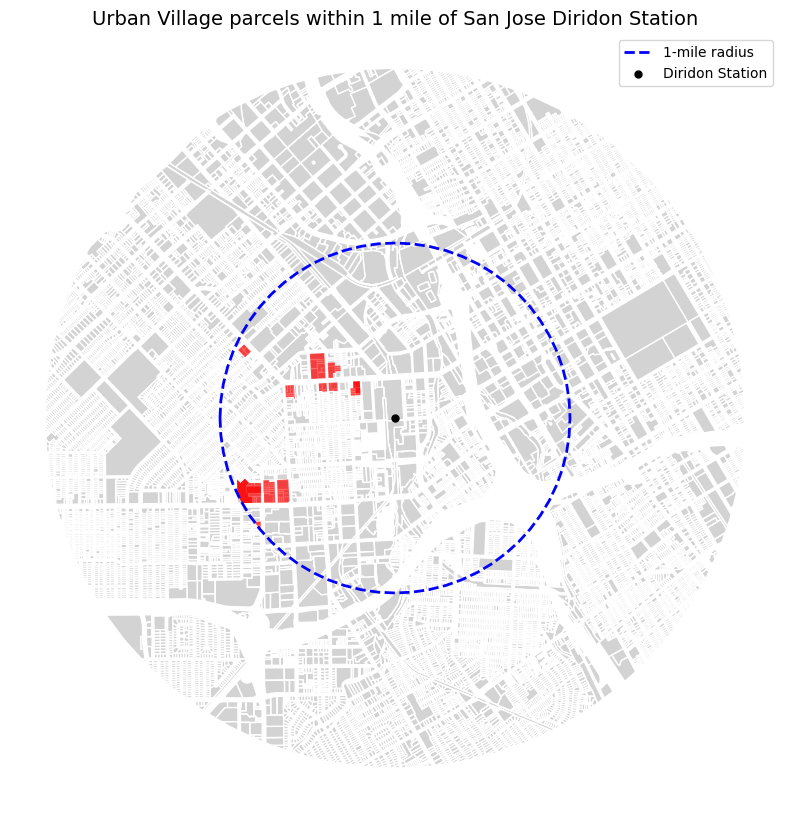

In [22]:

# 5. Plot 
fig, ax = plt.subplots(figsize=(10,10))

# add parcel base map (zoomed into 2-mile area for viewing)
parcels_within_2mile.plot(ax=ax, color="lightgrey", edgecolor="white")

# highlight only UV parcels within 1 mile
uv_within_1mile.plot(ax=ax, color="red", alpha=0.7)

# add buffers
buffer_1mile.boundary.plot(ax=ax, color="blue", linestyle="--", linewidth=2, label="1-mile radius")

# add station marker
diridon_station.plot(ax=ax, color="black", marker=".", markersize=100, label="Diridon Station")

# format
ax.set_title("Urban Village parcels within 1 mile of San Jose Diridon Station", fontsize=14)
ax.legend()
ax.axis('off')

plt.show()

#### 3.3 Count

In [23]:
print(f"Total parcels within 1 mile: {len(parcels_within_1mile)}")
print(f"Total UV parcels within 1 mile: {len(uv_within_1mile)}")

Total parcels within 1 mile: 4898
Total UV parcels within 1 mile: 79


### 4. San Jose and census data analysis

Choose two or three census characteristics related to evaluating aspects of opportunity,
economic mobility, or environmental sustainability near transit stations that might inform policy
design. Provide a 1-2 paragraph summary and at least one visualization that you think a San
Jose government official might want to see to better understand the characteristics of the area
within two miles of Diridon Station. As indicated in the data section above you can use whatever
source of census data you are most comfortable with. You may need to perform a geographic
crosswalk here, which you may do however you wish.

#### 4.1 get census data

Here I pull 2018-2022 5-year ACS estimates on a number of census variables. I then merged them with the shapefiles for the City of San Jose as described above. While block group data might have been helpful here because it is more granular, I have found that data below the census tract level can be unreliable, that is have very large margins of errror. This is especially true for income and economic mobility data that I might want to use. 

In [24]:
#
# Pull ACS data
# ----------------------------------------
 
# import libraries 
# ---------
from pygris import validate_state
from pygris.data import get_census

# define census variables and labels
# ---------
acs_vars = {
    "median_age": "B01002_001E",
    "median_income": "B19013_001E",

    # Rent burden
    "total_renter_households": "B25070_001E",
    "rent_<15": "B25070_002E",
    "rent_15_19": "B25070_003E",
    "rent_20_24": "B25070_004E",
    "rent_25_29": "B25070_005E",
    "rent_30_34": "B25070_006E",
    "rent_35_39": "B25070_007E",
    "rent_40_49": "B25070_008E",
    "rent_50_plus": "B25070_009E",

    # Poverty
    "poverty_universe": "B17001_001E",
    "below_poverty": "B17001_002E",

    # Vehicle availability
    "total_households": "B08201_001E",
    "no_vehicle": "B08201_002E",

    # Tenure (renters vs owners)
    "tenure_total": "B25003_001E",
    "owner_occupied": "B25003_002E",
    "renter_occupied": "B25003_003E",

    # commute mode (B08301)
    "total_workers": "B08301_001E",
    "drove": "B08301_002E",
    "public_transit_total": "B08301_010E",
    "bus": "B08301_011E",
    "subway": "B08301_012E",
    "commuter_rail": "B08301_013E",  # long-distance train or commuter rail
    "light_rail": "B08301_014E",  # long-distance train or commuter rail
    "bike": "B08301_018E",
    "walked": "B08301_019E",
    "worked_home": "B08301_021E",

    # Median gross rent
    "median_rent": "B25064_001E",

    # Units in structure (B25024)
    "units_total": "B25024_001E",
    "units_1_detached": "B25024_002E",
    "units_1_attached": "B25024_003E",
    "units_2": "B25024_004E",
    "units_3_4": "B25024_005E",
    "units_5_9": "B25024_006E",
    "units_10_19": "B25024_007E",
    "units_20_49": "B25024_008E",
    "units_50_plus": "B25024_009E",
    "units_mobile": "B25024_010E",
    "units_other": "B25024_011E",

    # vacancy rate (B25002)
    "housing_units_total": "B25002_001E",
    "housing_units_occupied": "B25002_002E",
    "housing_units_vacant": "B25002_003E",

    # race/ethnicity (B02001 & B03003)
    "race_total": "B02001_001E",
    "white": "B02001_002E",
    "black": "B02001_003E",
    "asian": "B02001_005E",
    "hisp_total": "B03003_001E",
    "hispanic": "B03003_003E",

    # education (B15003)
    "edu_total": "B15003_001E",
    "bachelors": "B15003_022E",
    "masters": "B15003_023E",
    "professional": "B15003_024E",
    "doctorate": "B15003_025E",

    # Income inequality
    "gini": "B19083_001E"
}

# pull data
# --------- 
ca_acs = get_census(
    dataset="acs/acs5",
    variables=list(acs_vars.values()),
    year=2022,
    params={
        "for": "tract:*",
        "in": f"state:{validate_state('CA')}"
    },
    guess_dtypes=True,
    return_geoid=True
)

# rename
# ---------
ca_acs = ca_acs.rename(columns={v: k for k, v in acs_vars.items()})

# calculate new variables
# ---------
# rent burden
ca_acs["rent_burdened_count"] = (
    ca_acs["rent_30_34"] +
    ca_acs["rent_35_39"] +
    ca_acs["rent_40_49"] +
    ca_acs["rent_50_plus"]
)
ca_acs["rent_burdened_pct"] = ca_acs["rent_burdened_count"] / ca_acs["total_renter_households"] * 100

# poverty
ca_acs["poverty_rate"] = ca_acs["below_poverty"] / ca_acs["poverty_universe"] * 100

# tenure
ca_acs["pct_renters"] = ca_acs["renter_occupied"] / ca_acs["tenure_total"] * 100
ca_acs["pct_homeowners"] = ca_acs["owner_occupied"] / ca_acs["tenure_total"] * 100

# mode of transportation 
ca_acs["no_vehicle_pct"] = ca_acs["no_vehicle"] / ca_acs["total_households"] * 100
ca_acs["public_transit_pct"] = ca_acs["public_transit_total"] / ca_acs["total_workers"] * 100
ca_acs["drove_pct"] = ca_acs["drove"] / ca_acs["total_workers"] * 100
ca_acs["bike_pct"] = ca_acs["bike"] / ca_acs["total_workers"] * 100
ca_acs["walked_pct"] = ca_acs["walked"] / ca_acs["total_workers"] * 100
ca_acs["commuter_rail_pct"] = ca_acs["commuter_rail"] / ca_acs["total_workers"] * 100
ca_acs["light_rail_pct"] = ca_acs["light_rail"] / ca_acs["total_workers"] * 100
ca_acs["worked_home_pct"] = ca_acs["worked_home"] / ca_acs["total_workers"] * 100

# units
ca_acs["single_family_units"] = ca_acs["units_1_detached"] + ca_acs["units_1_attached"]
ca_acs["small_multifamily_units"] = ca_acs["units_2"] + ca_acs["units_3_4"]
ca_acs["medium_multifamily_units"] = ca_acs["units_5_9"] + ca_acs["units_10_19"]
ca_acs["large_multifamily_units"] = ca_acs["units_20_49"] + ca_acs["units_50_plus"]
ca_acs["other_units"] = ca_acs["units_mobile"] + ca_acs["units_other"]
ca_acs["pct_single_family"] = ca_acs["single_family_units"] / ca_acs["units_total"] * 100
ca_acs["pct_small_multifamily"] = ca_acs["small_multifamily_units"] / ca_acs["units_total"] * 100
ca_acs["pct_medium_multifamily"] = ca_acs["medium_multifamily_units"] / ca_acs["units_total"] * 100
ca_acs["pct_large_multifamily"] = ca_acs["large_multifamily_units"] / ca_acs["units_total"] * 100
ca_acs["pct_other"] = ca_acs["other_units"] / ca_acs["units_total"] * 100

# vacancy rate
ca_acs["vacancy_rate"] = ca_acs["housing_units_vacant"] / ca_acs["housing_units_total"] * 100

# race/ethnicity
ca_acs["pct_white"] = ca_acs["white"] / ca_acs["race_total"] * 100
ca_acs["pct_black"] = ca_acs["black"] / ca_acs["race_total"] * 100
ca_acs["pct_asian"] = ca_acs["asian"] / ca_acs["race_total"] * 100
ca_acs["pct_latino"] = ca_acs["hispanic"] / ca_acs["hisp_total"] * 100

# education
ca_acs["college_plus"] = (
    ca_acs["bachelors"] +
    ca_acs["masters"] +
    ca_acs["professional"] +
    ca_acs["doctorate"]
)
ca_acs["pct_college_plus"] = ca_acs["college_plus"] / ca_acs["edu_total"] * 100


# check
ca_acs.head()


Using FIPS code '06' for input 'CA'


,median_age,median_income,total_renter_households,rent_<15,rent_15_19,rent_20_24,rent_25_29,rent_30_34,rent_35_39,rent_40_49,rent_50_plus,poverty_universe,below_poverty,total_households,no_vehicle,tenure_total,owner_occupied,renter_occupied,total_workers,drove,public_transit_total,bus,subway,commuter_rail,light_rail,bike,walked,worked_home,GEOID,median_rent,units_total,units_1_detached,units_1_attached,units_2,units_3_4,units_5_9,units_10_19,units_20_49,units_50_plus,units_mobile,units_other,housing_units_total,housing_units_occupied,housing_units_vacant,race_total,white,black,asian,hisp_total,hispanic,edu_total,bachelors,masters,professional,doctorate,gini,rent_burdened_count,rent_burdened_pct,poverty_rate,pct_renters,pct_homeowners,no_vehicle_pct,public_transit_pct,drove_pct,bike_pct,walked_pct,commuter_rail_pct,light_rail_pct,worked_home_pct,single_family_units,small_multifamily_units,medium_multifamily_units,large_multifamily_units,other_units,pct_single_family,pct_small_multifamily,pct_medium_multifamily,pct_large_multifamily,pct_other,vacancy_rate,pct_white,pct_black,pct_asian,pct_latino,college_plus,pct_college_plus
0,50.8,234236.0,127,20,8,81,0,10,0,0,8,3248,142,1377,95,1377,1250,127,1582,771,145,41,95,9,0,0,92,564,06001400100,3501.0,1496,1100,360,0,0,8,0,0,0,28,0,1496,1377,119,3269,2385,171,477,3269,167,2522,946,665,223,287,0.4228,18,14.173228,4.371921,9.222948,90.777052,6.899056,9.165613,48.735777,0.000000,5.815424,0.568900,0.000000,35.651075,1460,0,8,0,28,97.593583,0.000000,0.534759,0.000000,1.871658,7.954545,72.958091,5.230957,14.591618,5.108596,2121,84.099921
1,43.4,225500.0,386,69,43,80,41,111,9,0,5,2147,161,876,83,876,490,386,1124,312,287,14,253,20,0,37,21,455,06001400200,2500.0,913,579,17,23,73,105,104,9,3,0,0,913,876,37,2147,1535,38,251,2147,159,1740,599,524,229,151,0.4084,125,32.383420,7.498836,44.063927,55.936073,9.474886,25.533808,27.758007,3.291815,1.868327,1.779359,0.000000,40.480427,596,96,209,12,0,65.279299,10.514786,22.891566,1.314348,0.000000,4.052574,71.495109,1.769912,11.690731,7.405682,1503,86.379310
2,37.8,164000.0,1691,182,173,296,151,183,205,146,93,5592,396,2638,367,2638,947,1691,3301,1033,921,52,704,136,29,106,97,1077,06001400300,2335.0,2851,1224,64,230,421,278,55,237,342,0,0,2851,2638,213,5619,3403,529,635,5619,568,4514,1944,1084,336,248,0.4615,627,37.078652,7.081545,64.101592,35.898408,13.912055,27.900636,31.293547,3.211148,2.938503,4.119964,0.878522,32.626477,1288,651,333,579,0,45.177131,22.834093,11.680112,20.308664,0.000000,7.471063,60.562378,9.414487,11.300943,10.108560,3612,80.017723
3,37.4,158836.0,887,141,106,244,153,40,15,0,17,4226,419,1760,249,1760,873,887,2455,922,516,48,436,32,0,155,110,706,06001400400,2373.0,1975,935,130,270,335,188,48,69,0,0,0,1975,1760,215,4278,2832,525,373,4278,306,3255,1177,744,251,298,0.5063,72,8.117249,9.914813,50.397727,49.602273,14.147727,21.018330,37.556008,6.313646,4.480652,1.303462,0.000000,28.757637,1065,605,236,69,0,53.924051,30.632911,11.949367,3.493671,0.000000,10.886076,66.199158,12.272090,8.719028,7.152875,2470,75.883257
4,37.1,95078.0,878,19,107,119,50,168,99,23,55,3941,409,1679,143,1679,801,878,2210,967,395,68,292,24,11,124,37,673,06001400500,2175.0,1820,821,135,198,230,185,207,36,8,0,0,1820,1679,141,3949,1778,1000,376,3949,612,3013,1055,675,189,149,0.4571,345,39.293850,10.378077,52.293032,47.706968,8.516974,17.873303,43.755656,5.610860,1.674208,1.085973,0.497738,30.452489,956,428,392,44,0,52.527473,23.516484,21.538462,2.417582,0.000000,7.747253,45.024057,25.322867,9.521398,15.497594,2068,68.635911


#### 4.2 Get tract and place data

Here I import tract and place shapefiles from the `pygris` [library](https://walker-data.com/pygris/). I prefer this library since it is relatively simple, the library is stable, and does not require a Census API key. I pull all the shapefiles for all tracts and places in California. 

In [25]:
#
# Pull shapefiles
# ----------------------------------------

# tracts
from pygris import tracts
ca_tracts = tracts(state = "CA", cb = True, year=2022, cache=True) 

# places
from pygris import places
ca_places = places(state = "CA", cb = True, year=2022, cache=True) #

Using FIPS code '06' for input 'CA'
Using FIPS code '06' for input 'CA'


#### 4.3 Merge tract and place data 

Here I want to subset my census data to only the tracts that fall within the census place boundary of San Jose. Since census tracts might not map on perfectly to the San Jose Place boundary, I selected all tracts whose centroid fell within the San Jose Place shapefile. This is a standard method for combining shapes that might overlap. 

<positron-console-cell-26>:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



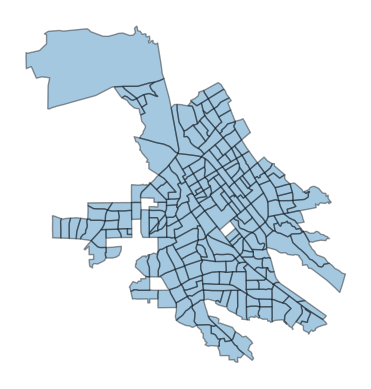

In [26]:
#
# Subset tract data to city boundary of San Jose
# ----------------------------------------

# get San Jose boundary
san_jose = ca_places[ca_places["NAME"] == "San Jose"]

# copy tract shapefile and create a centroid column
tracts_centroids = ca_tracts.copy()
tracts_centroids["centroid"] = tracts_centroids.centroid

# spatial join using centroids but keep original tract geometries
san_jose_tracts = gpd.sjoin(
    tracts_centroids.set_geometry("centroid"),  # use centroid for join
    san_jose,
    predicate="within"
).drop(columns="geometry")  # drop centroid geometry after join

# restore original tract geometries for mapping/visualizations
san_jose_tracts = san_jose_tracts.set_geometry(tracts_centroids.geometry)

# plot
check = san_jose_tracts.plot(edgecolor="black", alpha = .4)
check.set_axis_off()


#### 4.4 Merge in census data

Here I want to merge all Califonria census data with just the census tracts in San Jose that I identified using the centroid spatial join. This will merge all the census data to the San Jose geography for analysis.

In [27]:
#
# Merge san jose tract data with california census data
# ----------------------------------------
san_jose_tracts_with_acs = san_jose_tracts.merge(
    ca_acs,
    left_on="GEOID_left",   # from tracts
    right_on="GEOID",  # from ACS
    how="left"          # keeps all tracts, adds ACS data
)
san_jose_tracts_with_acs.head()

,STATEFP_left,COUNTYFP,TRACTCE,AFFGEOID_left,GEOID_left,NAME_left,NAMELSAD_left,STUSPS_left,NAMELSADCO,STATE_NAME_left,LSAD_left,ALAND_left,AWATER_left,centroid,index_right,STATEFP_right,PLACEFP,PLACENS,AFFGEOID_right,GEOID_right,NAME_right,NAMELSAD_right,STUSPS_right,STATE_NAME_right,LSAD_right,ALAND_right,AWATER_right,geometry,median_age,median_income,total_renter_households,rent_<15,rent_15_19,rent_20_24,rent_25_29,rent_30_34,rent_35_39,rent_40_49,rent_50_plus,poverty_universe,below_poverty,total_households,no_vehicle,tenure_total,owner_occupied,renter_occupied,total_workers,drove,public_transit_total,bus,subway,commuter_rail,light_rail,bike,walked,worked_home,GEOID,median_rent,units_total,units_1_detached,units_1_attached,units_2,units_3_4,units_5_9,units_10_19,units_20_49,units_50_plus,units_mobile,units_other,housing_units_total,housing_units_occupied,housing_units_vacant,race_total,white,black,asian,hisp_total,hispanic,edu_total,bachelors,masters,professional,doctorate,gini,rent_burdened_count,rent_burdened_pct,poverty_rate,pct_renters,pct_homeowners,no_vehicle_pct,public_transit_pct,drove_pct,bike_pct,walked_pct,commuter_rail_pct,light_rail_pct,worked_home_pct,single_family_units,small_multifamily_units,medium_multifamily_units,large_multifamily_units,other_units,pct_single_family,pct_small_multifamily,pct_medium_multifamily,pct_large_multifamily,pct_other,vacancy_rate,pct_white,pct_black,pct_asian,pct_latino,college_plus,pct_college_plus
0,06,085,500100,1400000US06085500100,06085500100,5001,Census Tract 5001,CA,Santa Clara County,California,CT,1922120,0,POINT (-121.89279 37.35849),85,06,68000,02411790,1600000US0668000,0668000,San Jose,San Jose city,CA,California,25,460811249,8089813,"POLYGON ((-121.90278 37.36256, -121.90178 37.3...",34.2,154868.0,1779,0,389,171,266,185,79,77,137,7850,698,2872,88,2872,1093,1779,4838,3782,174,100,0,30,44,76,123,623,06085500100,2817.0,3076,1084,412,199,43,69,63,216,990,0,0,3076,2872,204,7903,2059,584,1851,7903,3941,5532,1519,769,237,226,0.4183,478,26.869028,8.891720,61.942897,38.057103,3.064067,3.596527,78.172799,1.570897,2.542373,0.620091,0.909467,12.877222,1496,242,132,1206,0,48.634590,7.867360,4.291287,39.206762,0.000000,6.631990,26.053397,7.389599,23.421486,49.867139,2751,49.728850
1,06,085,503210,1400000US06085503210,06085503210,5032.10,Census Tract 5032.10,CA,Santa Clara County,California,CT,1595929,0,POINT (-121.82275 37.29039),85,06,68000,02411790,1600000US0668000,0668000,San Jose,San Jose city,CA,California,25,460811249,8089813,"POLYGON ((-121.83321 37.29342, -121.82894 37.2...",38.4,113113.0,336,0,32,17,75,18,43,11,42,4419,118,990,78,990,654,336,2251,2079,30,20,10,0,0,10,0,104,06085503210,2522.0,1033,824,205,4,0,0,0,0,0,0,0,1033,990,43,4435,949,174,1862,4435,2092,3020,442,119,24,4,0.3892,114,33.928571,2.670287,33.939394,66.060606,7.878788,1.332741,92.358952,0.444247,0.000000,0.000000,0.000000,4.620169,1029,4,0,0,0,99.612778,0.387222,0.000000,0.000000,0.000000,4.162633,21.397971,3.923337,41.984216,47.170237,589,19.503311
2,06,085,512030,1400000US06085512030,06085512030,5120.30,Census Tract 5120.30,CA,Santa Clara County,California,CT,1191726,0,POINT (-121.82418 37.23267),85,06,68000,02411790,1600000US0668000,0668000,San Jose,San Jose city,CA,California,25,460811249,8089813,"POLYGON ((-121.83061 37.23687, -121.82592 37.2...",40.8,182344.0,89,0,0,12,7,6,6,6,0,2922,69,905,32,905,816,89,1329,998,41,28,0,13,0,0,0,276,06085512030,3330.0,950,950,0,0,0,0,0,0,0,0,0,950,905,45,2922,1505,67,917,2922,409,1995,667,327,25,123,0.3948,18,20.224719,2.361396,9.834254,90.165746,3.535912,3.085026,75.094056,0.000000,0.000000,0.978179,0.000000,20.767494,950,0,0,0,0,100.000000,0.000000,0.000000,0.000000,0.000000,4.736842,51.505818,2.292950,31.382615,13.997262,1142,57.243108
3,06,085,503510,1400000US06085503510,06085503510,5035.10,Census Tract 5035.10,CA,Santa Clara County,California,CT,1032932,0,POINT (-121.81962 37.3494),85,06,68000,02411790,1600000US0668000,0668000,San Jose,San Jose city,CA,Californ

#### 4.5 Identify tracts within 2 miles of Diridon Station 

Here I want to add a new variable that identifies only census tracts within 2 miles of the Diridon Station so that I can look at census demographics by proximity to the main train station. 

In [28]:
#
# Use buffer to identify tracts within 2 miles of Diridon Station   
# ----------------------------------------
from shapely.geometry import Point

# 1. create diridon station point with decimal degrees
diridon_station = gpd.GeoDataFrame(
    geometry=[Point(-121.9028, 37.3292)],
    crs="EPSG:4326"
)

# 2. create Diridon buffer within 2 miles 
diridon_buffer = diridon_station.to_crs(epsg=3310).buffer(3218)  # 2 miles ≈ 3218 meters

# 3. reproject tracts to same CRS
tracts_proj = san_jose_tracts_with_acs.to_crs(epsg=3310)

# 4. add column identifying whether within 2 miles 
tracts_proj["within_2mi_diridon"] = tracts_proj.geometry.intersects(diridon_buffer.geometry.iloc[0]).astype(int)

# 5. bring back to original CRS
san_jose_tracts_with_acs = tracts_proj.to_crs(san_jose_tracts_with_acs.crs)

# 6. add categorical variable for mapping
san_jose_tracts_with_acs["within_2mi_diridon_cat"] = san_jose_tracts_with_acs["within_2mi_diridon"].map({
    0: "Outside 2 miles of station",
    1: "Within 2 miles of station"
})



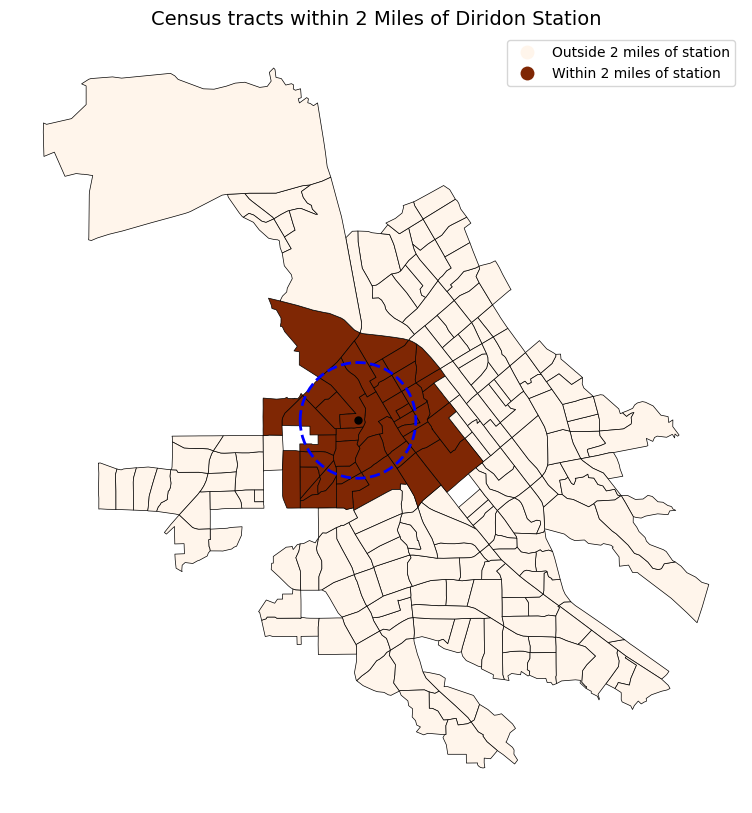

In [29]:
#
# Plot 
# ----------------------------------------

# ensure all layers are in the same CRS
diridon_station = diridon_station.to_crs(epsg=4269) 
buffer_2mile = buffer_2mile.to_crs(epsg=4269) 
railroad = railroad.to_crs(epsg=4269) 
bikeways = bikeways.to_crs(epsg=4269) 
bikeracks = bikeracks.to_crs(epsg=4269) 

# Map the column values to colors
#colors = san_jose_tracts_with_acs["within_2mi_diridon"].map(color_map)

# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")

# Plot tract shapefile colored by rent-burdened percent
san_jose_tracts_with_acs.plot(
    ax=ax,
    column="within_2mi_diridon_cat",
    categorical=True,       # <- treat values as categories
    legend=True,
    cmap="Oranges",        # Monotonic blue color scale
    edgecolor="black",   # optional: makes tract borders visible
    linewidth=0.5
)

# add station marker
diridon_station.plot(ax=ax, color="black", marker=".", markersize=100, label="Diridon Station")
buffer_2mile.boundary.plot(ax=ax, color="blue", linestyle="--", linewidth=2, label="1-mile radius")
#bikeways.plot(ax = ax, color = 'green', alpha = 0.5, legend = True)
#bikeracks.plot(ax = ax, color = 'red', alpha = 0.5, markersize = 2, legend = True)

# add title
ax.set_title("Census tracts within 2 Miles of Diridon Station", fontsize=14)
plt.show()

#### 4.6 Add equity score

Finally, I want to add equity score index data that comes directly from San Jose City calculations. These data can be obtained [here](https://data.sanjoseca.gov/dataset/equity-index-census-tracts), rely on ACS data, and serve as standard equity scores used by the city for planning purposes. I will be using the combined index scores for race and income, ranging from 2 (low priority) to 10 (high priority). 

In [30]:
#
# Add equity score
# ----------------------------------------

# specify geometry object of original tract data
geometry = san_jose_tracts_with_acs.geometry

# merge equity data into the GeoDataFrame
san_jose_tracts_with_acs_equity = san_jose_tracts_with_acs.merge(
    equity,
    left_on="GEOID_left",
    right_on="FIPSCODE",
    how="left"
)
# specify geometry since both shapefiles had geometry data and were renamed in the join
san_jose_tracts_with_acs_equity = gpd.GeoDataFrame(
    san_jose_tracts_with_acs_equity,
    geometry=geometry,
    crs=san_jose_tracts_with_acs.crs
)

# check
san_jose_tracts_with_acs_equity.head()



,STATEFP_left,COUNTYFP,TRACTCE,AFFGEOID_left,GEOID_left,NAME_left,NAMELSAD_left,STUSPS_left,NAMELSADCO,STATE_NAME_left,LSAD_left,ALAND_left,AWATER_left,centroid,index_right,STATEFP_right,PLACEFP,PLACENS,AFFGEOID_right,GEOID_right,NAME_right,NAMELSAD_right,STUSPS_right,STATE_NAME_right,LSAD_right,ALAND_right,AWATER_right,geometry_x,median_age,median_income,total_renter_households,rent_<15,rent_15_19,rent_20_24,rent_25_29,rent_30_34,rent_35_39,rent_40_49,rent_50_plus,poverty_universe,below_poverty,total_households,no_vehicle,tenure_total,owner_occupied,renter_occupied,total_workers,drove,public_transit_total,bus,subway,commuter_rail,light_rail,bike,walked,worked_home,GEOID_x,median_rent,units_total,units_1_detached,units_1_attached,units_2,units_3_4,units_5_9,units_10_19,units_20_49,units_50_plus,units_mobile,units_other,housing_units_total,housing_units_occupied,housing_units_vacant,race_total,white,black,asian,hisp_total,hispanic,edu_total,bachelors,masters,professional,doctorate,gini,rent_burdened_count,rent_burdened_pct,poverty_rate,pct_renters,pct_homeowners,no_vehicle_pct,public_transit_pct,drove_pct,bike_pct,walked_pct,commuter_rail_pct,light_rail_pct,worked_home_pct,single_family_units,small_multifamily_units,medium_multifamily_units,large_multifamily_units,other_units,pct_single_family,pct_small_multifamily,pct_medium_multifamily,pct_large_multifamily,pct_other,vacancy_rate,pct_white,pct_black,pct_asian,pct_latino,college_plus,pct_college_plus,within_2mi_diridon,within_2mi_diridon_cat,OBJECTID,FACILITYID,FIPSCODE,GEOID_y,CENSUSTRAC,GEOGRAPHIC,POPTOTAL,HOUSEHOLDC,RACEHISPAN,RACEHISP_1,RACEWHITEN,RACEWHITER,RACEBLACKN,RACEBLACKR,RACEASIANN,RACEASIANR,RACEOTHER,RACEOTHERR,RACEBIPOC,RACEBIPOCR,EQUITYSCOR,INCMEDIANI,EQUITYSC_1,INCMEDIANH,INCMEDIANW,INCMEDIANB,INCMEDIANA,INCMEDIANO,EQUITYSC_2,LANGGROUPP,LEPTOTAL,LEPRATIO,LEPSPANISH,LEPSPANI_1,LEPINDOEUR,LEPINDOE_1,LEPASIANPA,LEPASIAN_1,LEPOTHER,LEPOTHERRA,EQUITYSC_3,EDUGROUPPO,EDULESSTHA,EDULESST_1,EQUITYSC_4,LASTUPDATE,LASTUPDA_1,ENTERPRISE,INSANJOSE,Shape_Leng,Shape_Area,geometry_y,geometry
0,06,085,500100,1400000US06085500100,06085500100,5001,Census Tract 5001,CA,Santa Clara County,California,CT,1922120,0,POINT (-121.89279 37.35849),85,06,68000,02411790,1600000US0668000,0668000,San Jose,San Jose city,CA,California,25,460811249,8089813,"POLYGON ((-121.90278 37.36256, -121.90178 37.3...",34.2,154868.0,1779,0,389,171,266,185,79,77,137,7850,698,2872,88,2872,1093,1779,4838,3782,174,100,0,30,44,76,123,623,06085500100,2817.0,3076,1084,412,199,43,69,63,216,990,0,0,3076,2872,204,7903,2059,584,1851,7903,3941,5532,1519,769,237,226,0.4183,478,26.869028,8.891720,61.942897,38.057103,3.064067,3.596527,78.172799,1.570897,2.542373,0.620091,0.909467,12.877222,1496,242,132,1206,0,48.634590,7.867360,4.291287,39.206762,0.000000,6.631990,26.053397,7.389599,23.421486,49.867139,2751,49.728850,1,Within 2 miles of station,149,1,06085500100,1400000US06085500100,5001.00,"Census Tract 5001, Santa Clara County, California",7903,2872,3941,0.499,1200,0.152,527,0.067,1787,0.226,448,0.057,6703,0.848,4,154868,2,99519.0,195357.0,236029.0,174620.0,255000.0,6,7321,2026,0.277,1607,0.793,22,0.011,397,0.196,0,0.000,4,5532,994,0.180,4,ACSDT5Y2022,2024-04-23,REF-CDTR-0000000001,Yes,19857.630622,2.068743e+07,"POLYGON ((6153451.276 1956897.303, 6153492.1 1...","POLYGON ((-121.90278 37.36256, -121.90178 37.3..."
1,06,085,503210,1400000US06085503210,06085503210,5032.10,Census Tract 5032.10,CA,Santa Clara County,California,CT,1595929,0,POINT (-121.82275 37.29039),85,06,68000,02411790,1600000US0668000,0668000,San Jose,San Jose city,CA,California,25,460811249,8089813,"POLYGON ((-121.83321 37.29342, -121.82894 37.2...",38.4,113113.0,336,0,32,17,75,18,43,11,42,4419,118,990,78,990,654,336,2251,2079,30,20,10,0,0,10,0,104,06085503210,2522.0,1033,824,205,4,0,0,0,0,0,0,0,1033,990,43,4435,949,174,1862,4435,2092,3020,442,119,24,4,0.3892,114,33.928571,2.670287,33.939394,66.060606,7.878788,1.332741,92.358952,0.444247,0.000000,0.0000

#### 4.7 Create mapping function and several maps for analysis

I then create a set of maps to better visualize the distribution of some of the census demographics. The custom mapping function I use below is located in the `utils.py` and imported for use. It is flexible and allows me to create new maps by just changing a few specifications. I add a marker for Diridon Station downtown and a radius line to identify all tracts that fall within 2 miles of the station.  

##### Mapping equity

Using a natural breaks classification scheme with 4 groups, we can see a clear clustering of high equity scores (higher priority neighborhoods) just 2 miles southeast of the station. While much of the highest values (6-10) cluster outside of the 2 mile radius from the station, there are still some tracts with high equity scores within the radius.

Figure saved as ../output/maps/equity_score.pdf


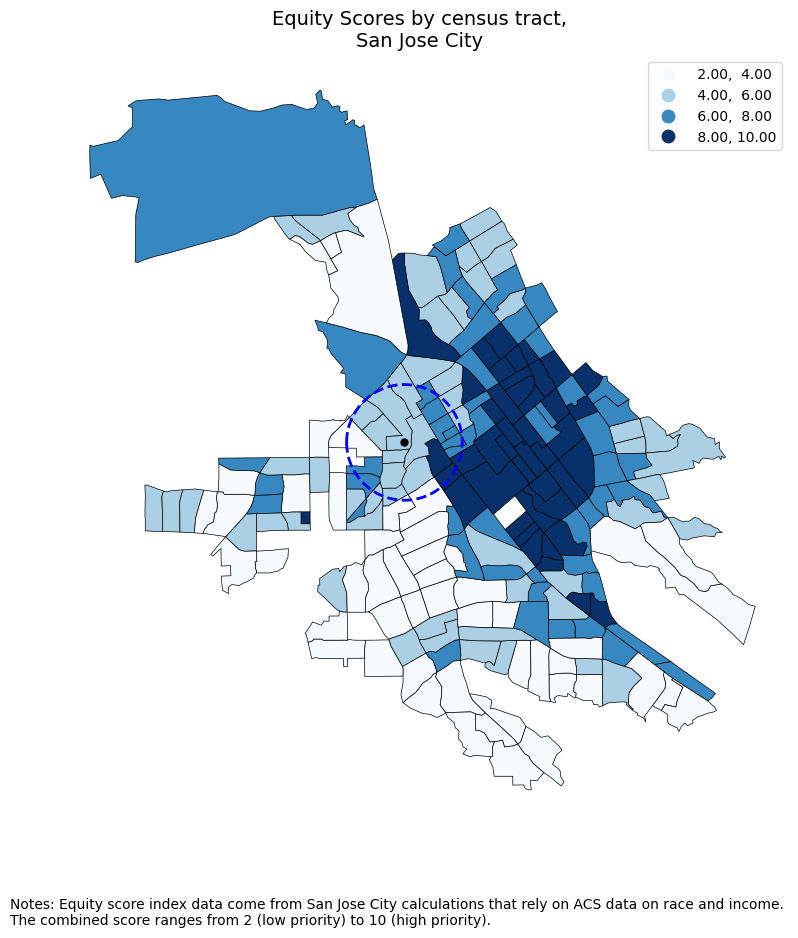

In [31]:
# import custom mapping function
from utils import choropleth_map

# 
# Equity score map
# ----------------------------------------
choropleth_map(
    gdf=san_jose_tracts_with_acs_equity,
    column="EQUITYSC_2", 
    title="Equity Scores by census tract, \nSan Jose City ",
    station_gdf=diridon_station,
    buffer_gdf=buffer_2mile,
    k = 4,
    notes="Notes: Equity score index data come from San Jose City calculations that rely on ACS data on race and income. \nThe combined score ranges from 2 (low priority) to 10 (high priority).",
    save=True,
    filename="../output/maps/equity_score.pdf"
)


##### Mapping median income

The results from this figure are not surprising, since the equity score on the previous figure are based in part by median income. Nevertheless, the clear cluster of lower median incomes (below $87,000) is quite stark and maps on very neatly to the equity findings from the previous figure. 

Figure saved as ../output/maps/median_income.pdf


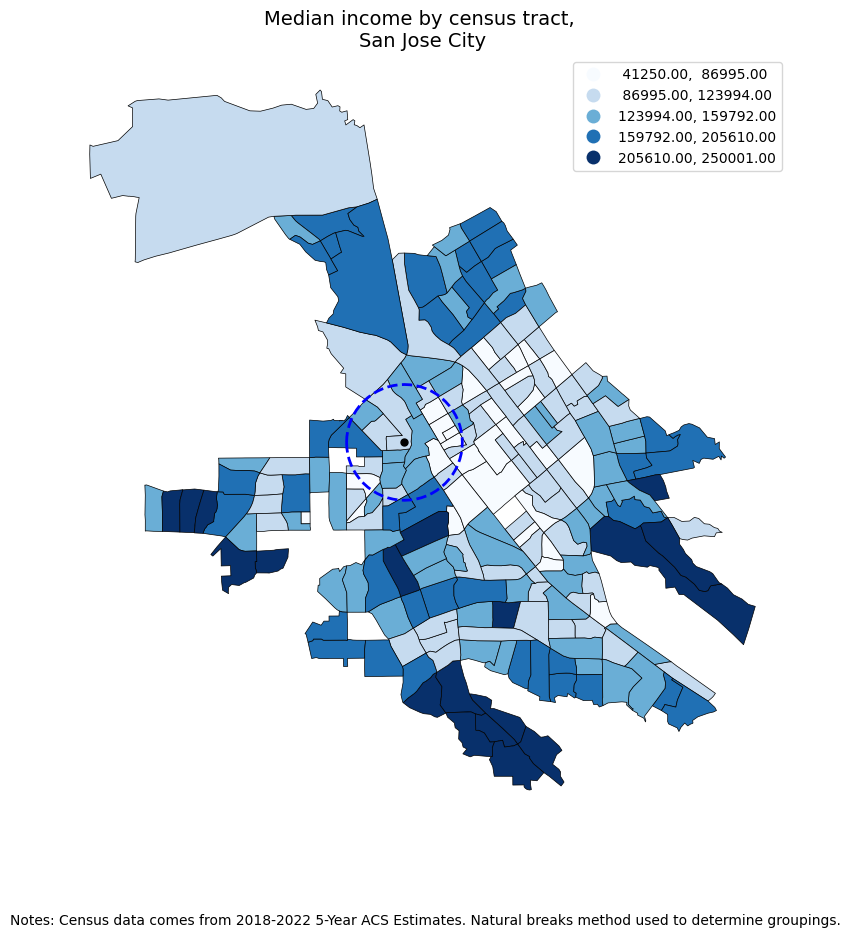

In [32]:
# 
# Median income
# ----------------------------------------
choropleth_map(
    gdf=san_jose_tracts_with_acs_equity,
    column="median_income",
    title="Median income by census tract, \nSan Jose City",
    station_gdf=diridon_station,
    buffer_gdf=buffer_2mile,
    k = 5,
    notes="Notes: Census data comes from 2018-2022 5-Year ACS Estimates. Natural breaks method used to determine groupings.",
    save=True,
    filename="../output/maps/median_income.pdf"
)


##### Mapping race 

This figure is again not surprising since it is also one of the components of the equity index, but the clear cluster reinforces previous findings:  strong racial segregation, with very low relative rates of white residents on the east side of the city. 

Figure saved as ../output/maps/percent_white.pdf


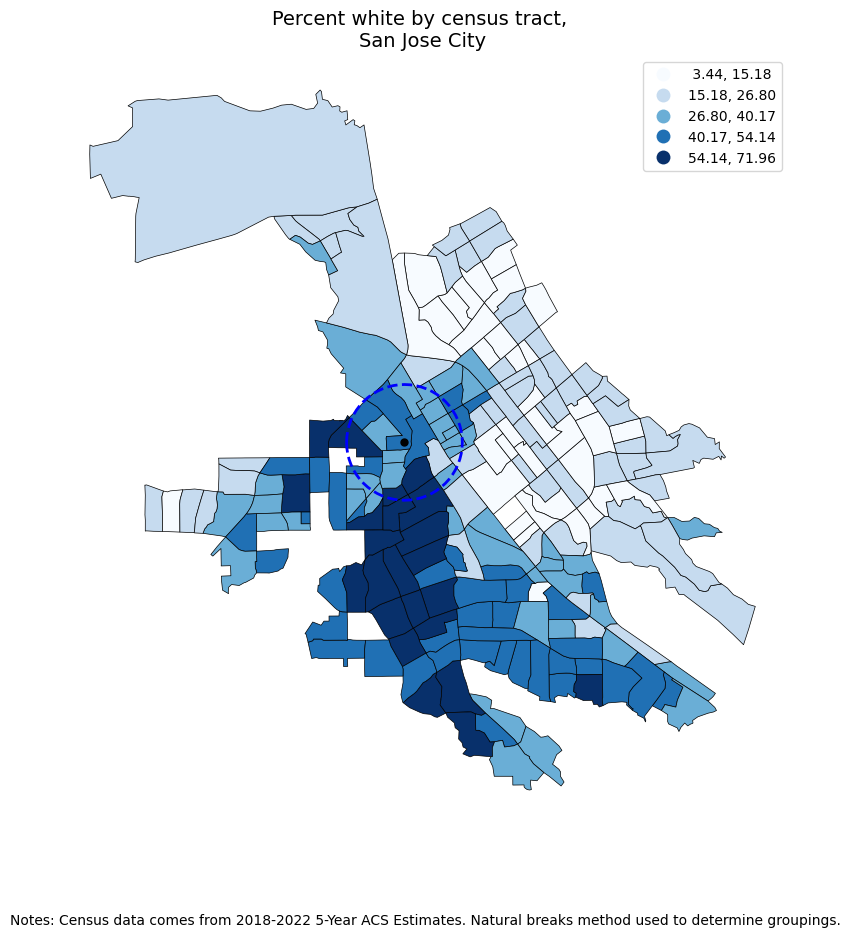

In [33]:
# 
# Race: percent white
# ----------------------------------------
choropleth_map(
    gdf=san_jose_tracts_with_acs_equity,
    column="pct_white", 
    title="Percent white by census tract, \nSan Jose City",
    station_gdf=diridon_station,
    buffer_gdf=buffer_2mile,
    k = 5,
    notes="Notes: Census data comes from 2018-2022 5-Year ACS Estimates. Natural breaks method used to determine groupings.",
    save=True,
    filename="../output/maps/percent_white.pdf"
)


##### Mapping vacancy 

This map shows that some of the city's highest vacancy rates are in the city center. This may be in part because of the lack of residential zoning in this area (this warrants further examination to make sure the census demographic finding of high vacancy rates is not an artifact of zoning). Nevertheless, beyond upzoning for more units, there is an opportunity to fill more of the current units available downtown within 2 miles of Diridon Station. 

Figure saved as ../output/maps/vacancy_rate.pdf


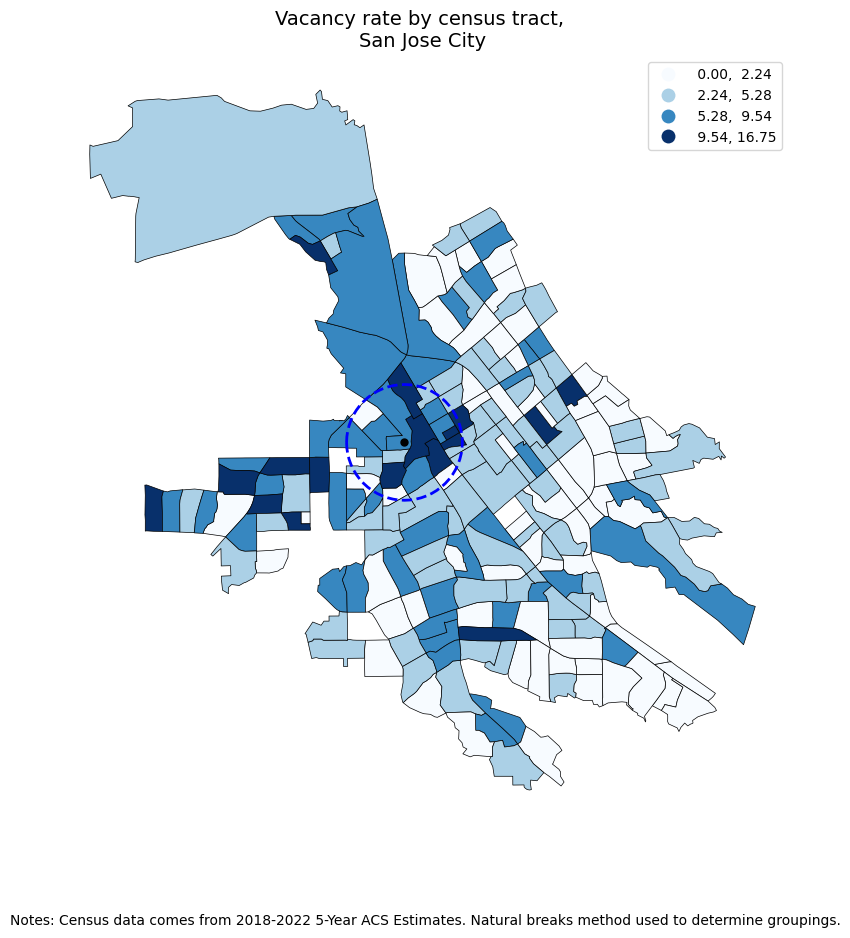

In [34]:
# 
# Vacancy rate
# ----------------------------------------
choropleth_map(
    gdf=san_jose_tracts_with_acs_equity,
    column="vacancy_rate", 
    title="Vacancy rate by census tract, \nSan Jose City",
    station_gdf=diridon_station,
    buffer_gdf=buffer_2mile,
    k = 4,
    notes="Notes: Census data comes from 2018-2022 5-Year ACS Estimates. Natural breaks method used to determine groupings.",
    save=True,
    filename="../output/maps/vacancy_rate.pdf"
)

##### Mapping renters 

This map clearly shows that many of the city's renters live near Diridon Station. Nearly every census tract within 2 miles of the station has a share of renters between 60 and 80 percent. This highights an opportunity for more affordable and rental housing within 2 miles of Diridon Station. 

Figure saved as ../output/maps/renters.pdf


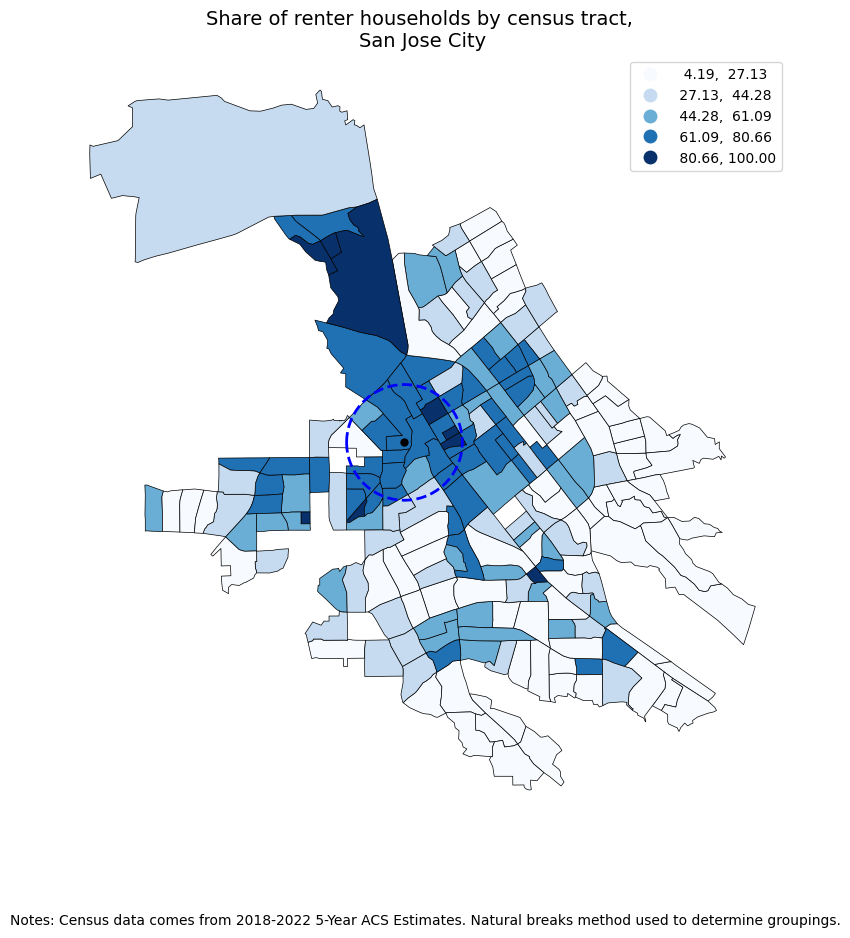

In [35]:
# 
# Renters
# ----------------------------------------
choropleth_map(
    gdf=san_jose_tracts_with_acs_equity,
    column="pct_renters", 
    title="Share of renter households by census tract, \nSan Jose City",
    station_gdf=diridon_station,
    buffer_gdf=buffer_2mile,
    k = 5,
    notes="Notes: Census data comes from 2018-2022 5-Year ACS Estimates. Natural breaks method used to determine groupings.",
    save=True,
    filename="../output/maps/renters.pdf"
)

##### Mapping public transit dependency 

This map clearly shows that some of the highest rates of households dependent on public transit live within 2 miles of Diridon Station. This is not that surprising, but there are many tracts just outside of that 2 mile radius to the east that also have higher rates of dependency on public transit. Many of these tracts are the same with high equity scores.

Figure saved as ../output/maps/public_transit.pdf


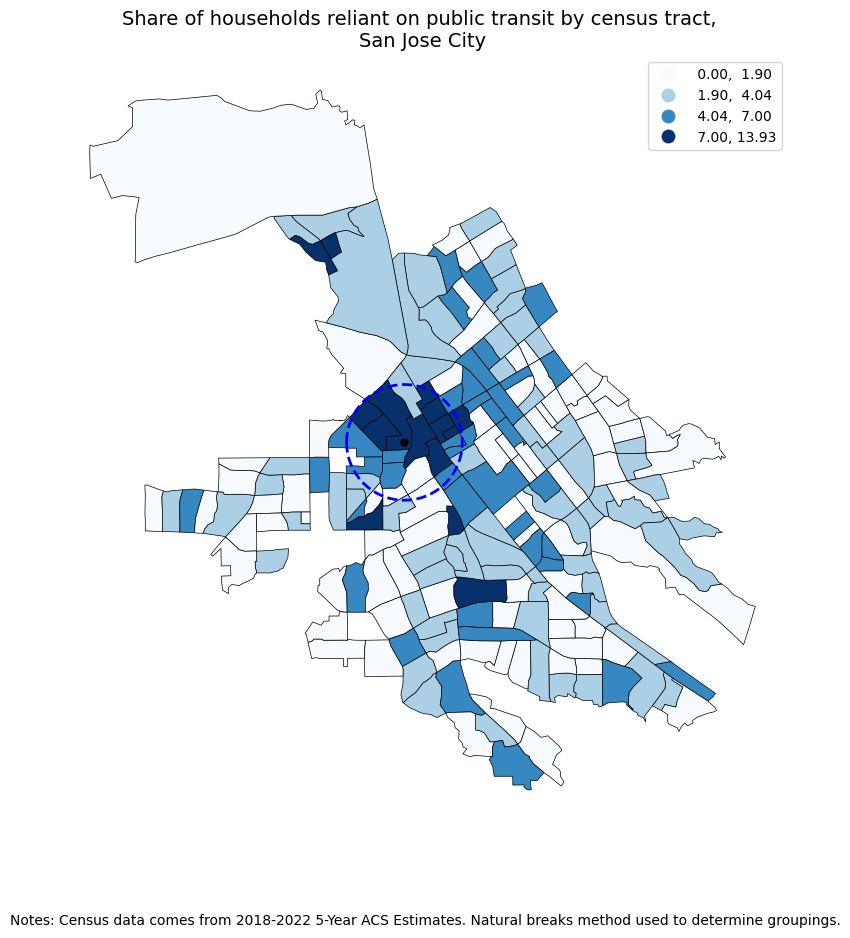

In [36]:
# 
# public transit
# ----------------------------------------
choropleth_map(
    gdf=san_jose_tracts_with_acs_equity,
    column="public_transit_pct", 
    title="Share of households reliant on public transit by census tract, \nSan Jose City",
    station_gdf=diridon_station,
    buffer_gdf=buffer_2mile,
    k = 4,
    notes="Notes: Census data comes from 2018-2022 5-Year ACS Estimates. Natural breaks method used to determine groupings.",
    save=True,
    filename="../output/maps/public_transit.pdf"
)

##### Figure to present to a city official


If I only had time to present 1 figure to a city official, I'd present the one below. In this figure, I've simply overlaid the zoning districts shapefile on the equity map and filtered so only zoning for Urban Village shows. When reading through the [Zoning Handbook](https://library.municode.com/ca/san_jose/codes/code_of_ordinances?nodeId=TIT20ZO_CH20.55URVIMIUSZODI), I came across *"Chapter 20.55 - URBAN VILLAGE AND MIXED USE ZONING DISTRICTS"* that describes Urban Villages as a major strategy for growth. It suggests that this type of zoning can be a growth strategy to achieve "active, dense, mixed use growth areas and for identifying locations for public open spaces within the city." What was somewhat surprising here is how little of the city is zoned for Urban Villages, particularly the 2-mile zone near the Diridon Station and the in the high equity area just east of the station. I would assume these areas would be priorities for development, growth, and economic opportunity, yet they are not sufficiently zoned for that. 

In speaking with a city official, I would try to communicate that the City's stated growth and development goals are somewhat misaligned with the City's need. To better align with the City's own stated equity goals, more Urban Village zoning should be located near Diridon station and in the lower-income and non-White neighborhoods just to the east. 

There are two shortcomings with this map that I'd like to address before such a meeting. First, I am aware of the Urban Village Commercial zoning and would like to dig further into that category to better understand the extent to which it is (1) part of the "Urban Village as growth strategy discourse", (2) how much residential housing it would produce (Urban Village is 100% Residential du/ac of 55-250, but I can't find anything on UVC), and (3) whether incorporating UVC into the map would dramatically change the map findings (I don't think so). The second shortcoming is technical. I'm having a bit of trouble with the map legends. The legend for the zoning layer is not properly displayed and I'm not able to add legend titles. I was able to save the first legend and then manually add it using `ax.add_artist(leg1)`, but the legends are not where I would like them for a presentation to city official. I'd also like to add legend titles, but that also seems a bit complicated with the multiple legends.


<positron-console-cell-37>:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler


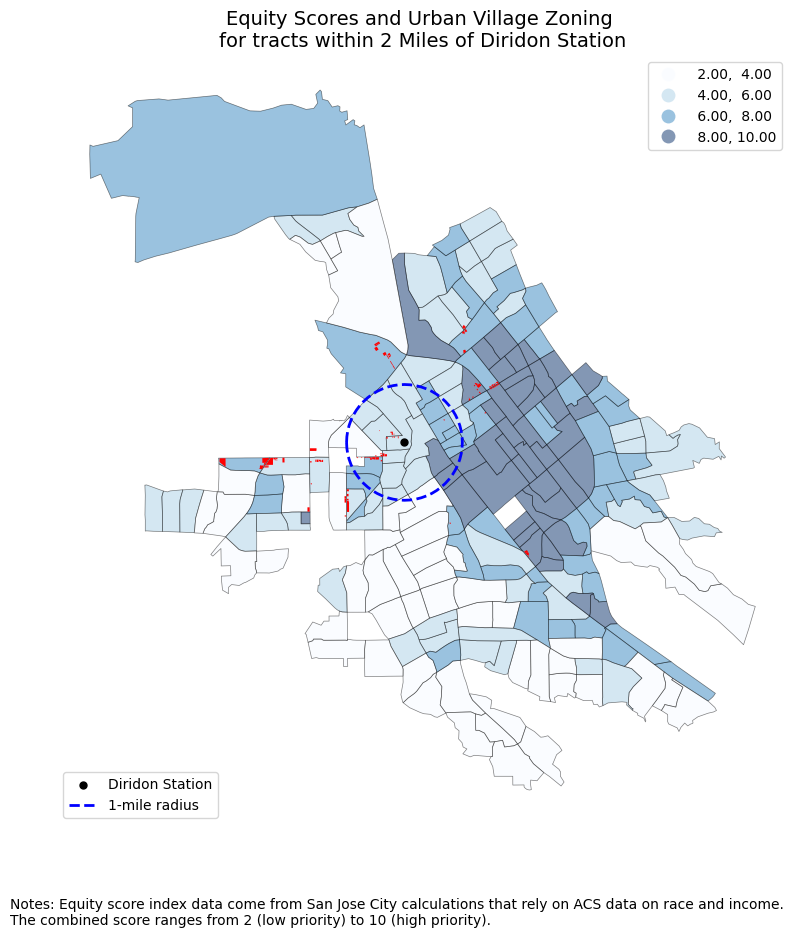

In [37]:
# 
# Final equity score map
# ----------------------------------------

# ensure consistent CRS
diridon_station = diridon_station.to_crs(epsg=4269) 
buffer_2mile = buffer_2mile.to_crs(epsg=4269) 
zoning_uv = zoning_uv.to_crs(epsg=4269) 

fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")

# choropleth
san_jose_tracts_with_acs_equity.plot(
    ax=ax,
    column="EQUITYSC_2",
    scheme="NaturalBreaks",
    k = 4, 
    legend=True,
    alpha = 0.5,
    cmap="Blues",        # Monotonic blue color scale
    edgecolor="black",   
    linewidth=0.5
)
# save legend from first plot 
leg1 = ax.get_legend() 

# add additional overlays
diridon_station.plot(ax=ax, color="black", marker=".", markersize=100, label="Diridon Station")
buffer_2mile.boundary.plot(ax=ax, color="blue", linestyle="--", linewidth=2, label="1-mile radius")
zoning_uv.plot(ax=ax, color="red", alpha=1, legend = True, label="Zoning UV")
ax.legend(loc="lower left")
ax.add_artist(leg1) # add the first legend back in

# add title
ax.set_title("Equity Scores and Urban Village Zoning \nfor tracts within 2 Miles of Diridon Station", fontsize=14)
# add note at bottom left
fig.text(
    0.1, 0.01,                    
    "Notes: Equity score index data come from San Jose City calculations that rely on ACS data on race and income. \nThe combined score ranges from 2 (low priority) to 10 (high priority).", 
    ha="left", fontsize=10)
plt.savefig("../output/maps/final_equity_map.pdf", format="pdf", bbox_inches="tight")  
plt.show()

## SECTION B 

**PROMPT:** This open-ended section provides an opportunity to showcase data skills relevant to the role. This is meant to be relatively brief - a paragraph or two describing the project and then around 40 lines1 of code in Python. For a non-exhaustive list of possibilities: Is there a tricky section of a data pipeline that highlights your meticulous nature? Did you develop a useful predictive model? Do you have a data visualization that you think is impactful? Do you have a particularly thoughtful way of doing exploratory data analysis that you want to show off? Sharing code via GitHub is preferred but not required.

**WHAT I DID:** This exercise has shown me that this position will require a number of important skills--e.g., careful geospatial skills, deep critical thinking, and a strong sense of project prioritization, among others. 

One dimension of the keys skills I used in this program that I'd like to highlight is my emphasis on reproducibility and functional programming. While there is room for improvement in my submission, I strove to make as much of it as reproducible and clear as possible. For example, I was careful to add a requirement.txt that the reader could run to recreate my virtual environment exactly with commandline instructions on how to do it. I clearly organized my work using headers that matched the exercise document, I tracked iterative changes after an initial push using GitHub and made the repo publicly available. I stress these skills because my sense is that this position will require very meticulous coding and data management work to create new data sets, delve into city-specific documentation, and conduct analyses. Clear documentation will not only make my work easier to pass off to others, but will also guard against coding errors and make it easier for others to check my work and reproduce it. 

Another dimension of this project I’d like to highlight is my use of utility functions, like the flexible mapping function I used above (`choropleth_map`, which is located in the separate `utils.py` file) and reproduced below. I lean on functional programming for a few reasons. First, it declutters the analysis script, making it easier to read and easier to debug. To further the functional programming paradigm here, I might save the function into personal library I automatically import before I start coding. This ensures my scripts stay clean and my functions are easy to update. This kind of centralization also lets colleagues use the same functions, which would serve to standardize map-making across the organization. Second, utility functions let me quickly generate multiple visualizations, helping me spot patterns without rewriting the same code. That flexibility also speeds up my workflow: I can create and save a series of maps with just a few keystrokes. Third, using a function instead of copy-pasting code reduces human error. By trusting the function to work and using it instead of copy-pasting, I can eliminate a common source of coding mistakes. Finally, the function’s flexibility means I can adjust parameters on the fly. For example, I added a `notes` parameter that lets me add annotations when I want, but defaults to `None` so I don’t have to specify it every time. This allows me to use the function in a wider variety of cases.

Reproducibility and flexible functional programming are at the heart of how I try to make my work more accessible, speed up my workflow, and guard against coding errors.

#### Flexible mapping function

In [38]:
#
# Flexible mapping function
# ----------------------------------------
# Create a choropleth map that plots a station point and buffer overlays.
# Can optionally save the figure to a file and add notes at the bottom.

# libraries
import matplotlib.pyplot as plt
import mapclassify

# mapping function
def choropleth_map(
    gdf,                                    # data with geometry
    column,                                 # column to display
    title,                                  # title
    station_gdf=None,                       # station overlay
    buffer_gdf=None,                        # buffer overlay
    k=5,                                    # number of classes
    cmap="Blues",                           # color scheme
    save=False,                             # save figure
    filename="../output/choropleth_map.pdf", # file name
    notes=None                              # notes
):    
    # ensure consistent CRS
    gdf = gdf.to_crs(epsg=4269)
    if station_gdf is not None:
        station_gdf = station_gdf.to_crs(epsg=4269)
    if buffer_gdf is not None:
        buffer_gdf = buffer_gdf.to_crs(epsg=4269)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    
    # main choropleth map
    gdf.plot(
        ax=ax,
        column=column,
        scheme="NaturalBreaks",
        k=k,
        legend=True,
        cmap=cmap,
        edgecolor="black",
        linewidth=0.5
    )
    
    # station overlay
    if station_gdf is not None:
        station_gdf.plot(
            ax=ax, color="black", marker=".", markersize=100, label="Station"
        )
    
    # 2 mile radius overlay
    if buffer_gdf is not None:
        buffer_gdf.boundary.plot(
            ax=ax, color="blue", linestyle="--", linewidth=2, label="Buffer"
        )
    
    # title
    ax.set_title(title, fontsize=14)
    
    # footnotes 
    if notes:
        fig.text(0.1, 0.01, notes, ha='left', fontsize=10)
    
    # save
    if save:
        plt.savefig(filename, format="pdf", bbox_inches="tight")
        print(f"Figure saved as {filename}")

    
    plt.show()
